# 1. Kütüphanelerin Yüklenmesi ve Ayarlar

Bu bölümde model eğitimi için gerekli PyTorch kütüphanelerini, görselleştirme araçlarını (Matplotlib) ve ilerleme çubuklarını (tqdm) yüklüyoruz.
Ayrıca, daha önceki adımda hazırladığımız `Veri_Düzenleme` modülünden veri yükleyici fonksiyonunu çağırıyoruz.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time

# --- ÇÖZÜM BURADA ---
# Klasöründeki dosya ismine tam bak, hangisiyse sadece o satırı çalıştır:

%run FET312_22040301043_DevTeam177_1.ipynb

print("Veri düzenleme modülü başarıyla yüklendi.")

--- Veri_Duzenleme.ipynb Test Modunda Çalıştırılıyor ---
Eğitim verisi yüklendi. Toplam 43 sınıf bulundu.
Train/Validation ayrımı yapıldı: 31367 Train, 7842 Validation
Test verisi yüklendi. Boyut: 12630
DataLoaders (train, val, test) başarıyla oluşturuldu.

Test başarılı. Sınıf sayısı: 43
Train loader'da 491 batch var.
Val loader'da 123 batch var.
Test loader'da 198 batch var.
İlk train batch boyutu (Resimler): torch.Size([64, 3, 64, 64])
İlk train batch boyutu (Etiketler): torch.Size([64])
Veri düzenleme modülü başarıyla yüklendi.


# 2. SimpleCNN Model Mimarisi

Burada, vize projesi için belirlenen "Base Model"imizi tanımlıyoruz.
Modelimiz **2 Evrişim (Convolution)** ve **2 Tam Bağlantılı (Linear)** katmandan oluşan, toplam 4 katmanlı, eğitilebilir basit bir yapıdır.

* **Conv Katmanları:** Görüntüden özellikleri (kenar, köşe vb.) çıkarır.
* **MaxPool:** Özellik haritasını küçülterek işlem yükünü azaltır.
* **Linear (Fully Connected):** Çıkarılan özelliklere göre sınıflandırma yapar.

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # 1. Evrişim Bloğu: Girdi(3 kanal) -> Çıktı(16 filtre)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Havuzlama: Boyutu yarıya indirir
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 2. Evrişim Bloğu: Girdi(16) -> Çıktı(32 filtre)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        # Tam Bağlantılı Katmanlar
        # Hesap: 32 (filtre) * 16 * 16 (son görüntü boyutu)
        self.fc1 = nn.Linear(in_features=32 * 16 * 16, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x)))
        # Conv2 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))
        # Düzleştirme (Flatten)
        x = x.view(-1, 32 * 16 * 16) 
        # Linear1 -> ReLU
        x = F.relu(self.fc1(x))
        # Çıktı Katmanı
        x = self.fc2(x)
        return x

# 3. Eğitim Hazırlığı (Setup)

Bu aşamada:
1.  **Veri Yükleme:** Eğitim ve validasyon verilerini `batch_size=64` ile yüklüyoruz.
2.  **Cihaz Seçimi:** GPU (cuda) varsa onu, yoksa CPU'yu seçiyoruz.
3.  **Model Kurulumu:** Modelimizi seçilen cihaza gönderiyoruz.
4.  **Hiperparametreler:**
    * **Loss Function:** Çoklu sınıflandırma için `CrossEntropyLoss`.
    * **Optimizer:** `Adam` optimizasyon algoritması (Learning rate: 0.001).

In [3]:
# --- A. Veriyi Hazırla ---
print("Veri yükleyiciler hazırlanıyor...")
# Sadece train ve val loader'ları alıyoruz
train_loader, val_loader, _, NUM_CLASSES = get_data_loaders(batch_size=64, num_workers=0)

if train_loader is None:
    raise RuntimeError("Veri yüklenemedi. Lütfen Veri_Düzenleme dosyasını kontrol edin.")

# --- B. Cihaz, Model, Loss ve Optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Modelin eğitileceği cihaz: {device}")

model = SimpleCNN(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model hazır. Toplam sınıf sayısı: {NUM_CLASSES}")

Veri yükleyiciler hazırlanıyor...
Eğitim verisi yüklendi. Toplam 43 sınıf bulundu.
Train/Validation ayrımı yapıldı: 31367 Train, 7842 Validation
Test verisi yüklendi. Boyut: 12630
DataLoaders (train, val, test) başarıyla oluşturuldu.
Modelin eğitileceği cihaz: cpu
Model hazır. Toplam sınıf sayısı: 43


# Ek: Veri Seti Analizi ve Görselleştirme

Model eğitimine başlamadan önce, veri setimizin dengesini ve içeriğini analiz ediyoruz. Bu adım, modelin hangi sınıflarda zorlanabileceğini öngörmek için kritiktir.

1.  **Sınıf Dağılımı (Bar Chart):** Eğitim setindeki 43 farklı trafik işareti sınıfının dağılımını gösterir. Bazı sınıfların diğerlerinden daha az örneğe sahip olması (dengesiz veri seti), modelin o sınıfları öğrenmesini zorlaştırabilir.
2.  **Rastgele Örnekler:** Veri düzenleme (preprocessing) ve normalizasyon işleminden geçmiş görüntülerin sağlamasını yapmak için rastgele örnekleri görselleştiriyoruz. Görüntüleri insan gözüyle anlamlı hale getirmek için "un-normalize" işlemi uyguluyoruz.

Veri yükleyiciler hazırlanıyor...
Sınıf dağılımı hesaplanıyor...


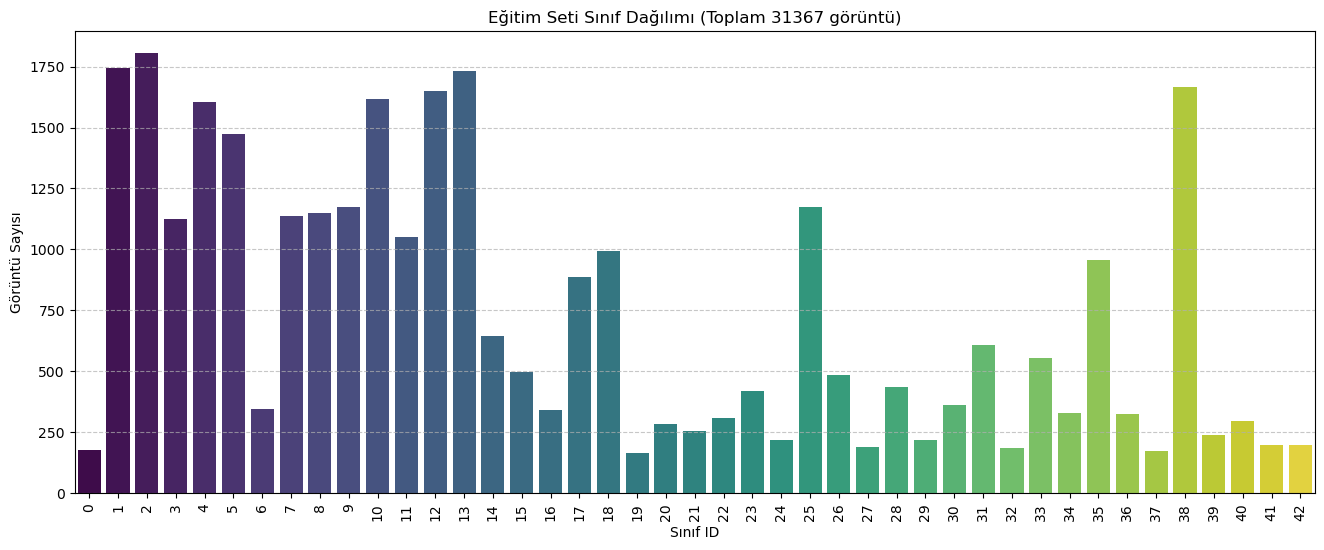


--- İşlenmiş Veriden Rastgele Örnekler ---


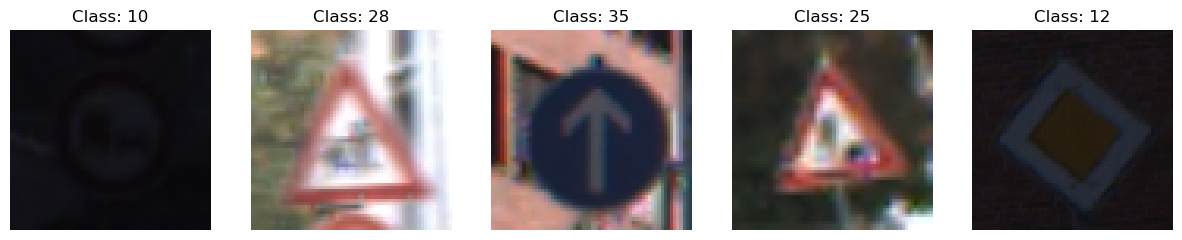

In [4]:
# --- EK HÜCRE: Veri Seti Analizi ve Görselleştirme ---

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. ADIM: ÖNCE VERİYİ YÜKLE (Hata almamak için bu satırı ekliyoruz)
print("Veri yükleyiciler hazırlanıyor...")
# Eğer train_loader daha önce tanımlanmadıysa burada tanımlıyoruz
if 'train_loader' not in locals():
    train_loader, val_loader, _, NUM_CLASSES = get_data_loaders(batch_size=64, num_workers=0)

# 2. Sınıf Dağılımı Grafiği (Bar Chart)
print("Sınıf dağılımı hesaplanıyor...")

# train_loader bir 'DataLoader'dır. İçindeki veri kümesine (dataset) ulaşmamız gerek.
# Veri seti 'random_split' ile bölündüğü için bir 'Subset' nesnesidir.
subset_indices = train_loader.dataset.indices # Train için seçilen resimlerin numaraları
all_targets = train_loader.dataset.dataset.targets # Orijinal veri setindeki tüm etiketler

# Sadece train indekslerine karşılık gelen etiketleri çekiyoruz
train_targets = [all_targets[i] for i in subset_indices] 

# Pandas ile sayım yapalım
class_counts = pd.Series(train_targets).value_counts().sort_index()

# Grafiği çiz
plt.figure(figsize=(16, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, legend=False, palette="viridis")
plt.title(f"Eğitim Seti Sınıf Dağılımı (Toplam {len(train_targets)} görüntü)")
plt.xlabel("Sınıf ID")
plt.ylabel("Görüntü Sayısı")
plt.xticks(rotation=90) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. İşlenmiş Veriden Rastgele Örnekler Gösterme
print("\n--- İşlenmiş Veriden Rastgele Örnekler ---")

# Bir batch (paket) veri çek
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Görüntüyü eski haline getirme (Un-normalize) fonksiyonu
def imshow(img):
    img = img / 2 + 0.5     # Normalize işlemini tersine çevir (-1,1 -> 0,1)
    npimg = img.numpy()     # Tensörden Numpy'a çevir
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (C, H, W) -> (H, W, C)

# Rastgele 5 resim seç
random_indices = np.random.choice(len(images), 5, replace=False)

plt.figure(figsize=(15, 4))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(1, 5, i + 1)
    imshow(images[idx])
    ax.set_title(f"Class: {labels[idx].item()}")
    plt.axis('off') 
plt.show()

# 4. Model Eğitimi (Training Loop)

Burası sürecin en uzun süren kısmıdır. Belirlenen `NUM_EPOCHS` (tur sayısı) kadar döngü çalışır.

**Her Epoch'ta:**
1.  **Train Modu:** Model ağırlıkları güncellenir. `train_loader`'dan veriler alınır, tahmin yapılır, hata (loss) hesaplanır ve `backward()` ile geriye yayılım yapılır.
2.  **Validation Modu:** Model ağırlıkları dondurulur (`no_grad`). Modelin o anki başarısı "görülmemiş" validasyon verisi üzerinde test edilir.
3.  **Kayıt:** Her epoch sonunda Loss ve Accuracy değerleri listelere kaydedilir.

In [5]:
# --- C. Eğitim Döngüsü ---
NUM_EPOCHS = 15
print(f"Eğitim {NUM_EPOCHS} epoch için başlıyor...")

train_losses = []
val_losses = []
val_accuracies = []

# Görsel bekleme
time.sleep(0.5)

for epoch in range(NUM_EPOCHS):
    # --- Eğitim Aşaması ---
    model.train() 
    running_train_loss = 0.0
    
    # İlerleme çubuğu (Train)
    train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)
    
    for images, labels in train_progress:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()           # Gradyanları sıfırla
        outputs = model(images)         # İleri besleme
        loss = criterion(outputs, labels) # Hata hesapla
        loss.backward()                 # Geri yayılım
        optimizer.step()                # Ağırlıkları güncelle
        
        running_train_loss += loss.item()
        train_progress.set_postfix(loss=running_train_loss / (train_progress.n + 1))

    # --- Validasyon Aşaması ---
    model.eval() 
    running_val_loss = 0.0
    correct, total = 0, 0
    
    # İlerleme çubuğu (Val)
    val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False)
    
    with torch.no_grad(): # Gradyan hesaplama kapalı
        for images, labels in val_progress:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            # Doğruluk hesabı
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            val_progress.set_postfix(loss=running_val_loss / (val_progress.n + 1))
    
    # Epoch sonu istatistikleri
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_acc = 100 * correct / total
    
    # Listelere kaydet
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {epoch_val_acc:.2f}%")

print("\n--- Eğitim Tamamlandı ---")

Eğitim 15 epoch için başlıyor...


Epoch [1/15] | Train Loss: 1.1374 | Val Loss: 0.3647 | Val Acc: 89.03%


Epoch [2/15] | Train Loss: 0.2018 | Val Loss: 0.1891 | Val Acc: 94.07%


Epoch [3/15] | Train Loss: 0.1011 | Val Loss: 0.1085 | Val Acc: 97.12%


Epoch [4/15] | Train Loss: 0.0751 | Val Loss: 0.1378 | Val Acc: 96.05%


Epoch [5/15] | Train Loss: 0.0439 | Val Loss: 0.0954 | Val Acc: 97.63%


Epoch [6/15] | Train Loss: 0.0413 | Val Loss: 0.1470 | Val Acc: 95.88%


Epoch [7/15] | Train Loss: 0.0332 | Val Loss: 0.1167 | Val Acc: 97.13%


Epoch [8/15] | Train Loss: 0.0272 | Val Loss: 0.0663 | Val Acc: 98.30%


Epoch [9/15] | Train Loss: 0.0188 | Val Loss: 0.0857 | Val Acc: 97.96%


Epoch [10/15] | Train Loss: 0.0183 | Val Loss: 0.0829 | Val Acc: 97.82%


Epoch [11/15] | Train Loss: 0.0202 | Val Loss: 0.0825 | Val Acc: 98.06%


Epoch [12/15] | Train Loss: 0.0214 | Val Loss: 0.1037 | Val Acc: 97.59%


Epoch [13/15] | Train Loss: 0.0152 | Val Loss: 0.0734 | Val Acc: 98.09%


Epoch [14/15] | Train Loss: 0.0151 | Val Loss: 0.0673 | Val Acc: 98.55%


Epoch [15/15] | Train Loss: 0.0067 | Val Loss: 0.0429 | Val Acc: 99.15%

--- Eğitim Tamamlandı ---


# 5. Modelin Kaydedilmesi ve Performans Grafikleri

Eğitim bittikten sonra:
1.  **Model Kaydı:** Eğitilmiş ağırlıkları (`state_dict`) `.pth` uzantılı bir dosya olarak diske kaydediyoruz. Bu dosya daha sonra test aşamasında kullanılacak.
2.  **Grafikler:**
    * **Sol Grafik:** Eğitim ve Validasyon kaybının (loss) düşüşünü gösterir. (Düşmesi iyidir).
    * **Sağ Grafik:** Validasyon doğruluğunun (accuracy) artışını gösterir. (Yükselmesi iyidir).

Model ağırlıkları 'SimpleCNN_model.pth' olarak kaydediliyor...
Kayıt başarılı.


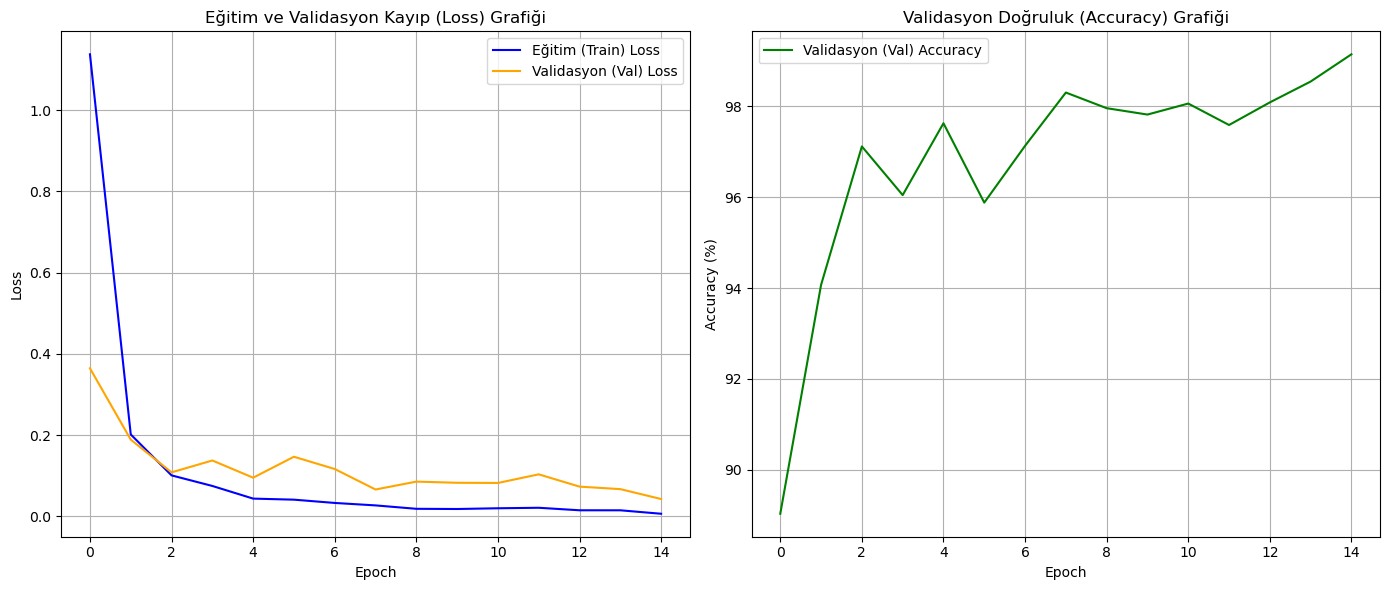

In [6]:
# --- D. Modeli Kaydetme ---
MODEL_SAVE_PATH = 'SimpleCNN_model.pth'
print(f"Model ağırlıkları '{MODEL_SAVE_PATH}' olarak kaydediliyor...")
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("Kayıt başarılı.")

# --- E. Grafikleri Çizme ---
plt.figure(figsize=(14, 6))

# 1. Loss Grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Eğitim (Train) Loss', color='blue')
plt.plot(val_losses, label='Validasyon (Val) Loss', color='orange')
plt.title('Eğitim ve Validasyon Kayıp (Loss) Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. Accuracy Grafiği
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validasyon (Val) Accuracy', color='green')
plt.title('Validasyon Doğruluk (Accuracy) Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('SimpleCNN_Egitim_Grafikleri.png') # Grafiği de kaydet
plt.show() # Notebook içinde göster